# Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from trendmaster import trend
import itertools
from scipy.stats import linregress
import datetime
import pickle
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon
from statsmodels.tsa import stattools
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [5]:
def saveDict(dictionary,filename):
    """
    Saves dictionary to pickle file in working directory.
    
    Parameters
    ----------
    dictionary: dict
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    Nothing
    """
    f = open(f"{filename}.pkl","wb")
    pickle.dump(dictionary,f)
    f.close()

def openDict(filename):
    """
    Opens dictionary from pickle file in working directory.
    
    Parameters
    ----------
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    dictionary
    """
    pickle_in = open(f"{filename}.pkl","rb")
    loadedDict = pickle.load(pickle_in)
    return loadedDict

In [37]:
sor = openDict("sorlandet_final")
ost = openDict("ostlandet_final")
vest = openDict("vestlandet_final")
trond = openDict("trondelag_final")
nord = openDict("nordland_final")
finn = openDict("finnmark_final")

norge = gpd.read_file("gis/Norge.shp")
regionLines = gpd.read_file("gis/Grense_Avrenningsregioner.shp")
stations = gpd.read_file("gis/Gauging_Stations.shp")

# Calculating trends

## Annual hydrological trends

### Annual sums

In [7]:
def annualSum(ts,years=30,endYear = 2012):
    """
    Calculates the annual total of a variable for a norwegian hydrological year.
    
    Parameters
    ----------
    ts: pandas.DataFrame
        table with time series data in column and datetime as index
    startYear: str
    endYear: str
        
    Returns
    -------
    pandas of total annual of variable
    """
    startYear = endYear-years+1
    years = np.arange(startYear,endYear+1)
    t = []
    for year in years:
        start = str(year)
        end = str(year+1)
        tslice = ts[f"{start}-09-01":f"{end}-08-31"]
        if pd.isnull(tslice).any():
            missing = pd.isnull(tslice).sum()
            total = tslice.shape[0]
            threshold = np.ceil(total*0.1)
            if missing>threshold:
                t.append(np.nan)
            else:
                t.append(tslice.sum(skipna=True))
        else:
            t.append(tslice.sum(skipna=False))
    return np.array(t)

In [48]:
def annualET(data, years = 30):
    df = data["metadata"]
    evapo = {}
    for c in data[f"final{years}"]:
        brepro = float(df[df.snumber==c].BREPRO)
        if brepro>10:
            print("Glaciation too high for water balance equation.")
            print("Skipping",c,"...")
            continue
        area = (df[df.snumber==c].areal).iloc[0]
        Q = annualSum((data["data"][c]["runoff"].runoff)*(86.4)/area,years=years)
        rainfall = annualSum(data["data"][c]["precip"],years=years)
        snowmelt = annualSum(data["data"][c]["snow"].qsw,years=years)
        P = rainfall + snowmelt
        ET = P - Q
        evapo[c] = ET
    return evapo

Glaciation too high for water balance.
Skipping 200268 ...


/Users/skam2905/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


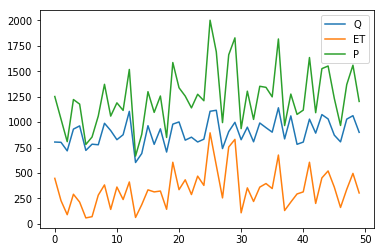

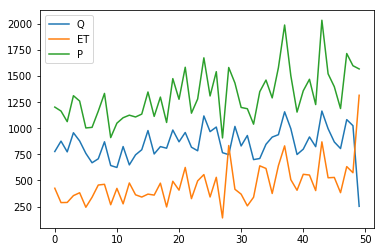

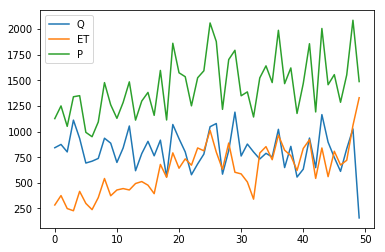

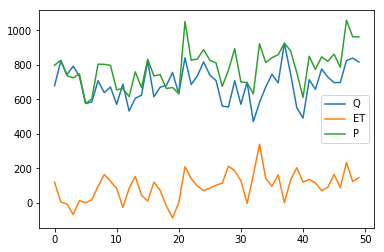

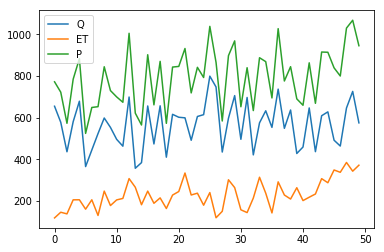

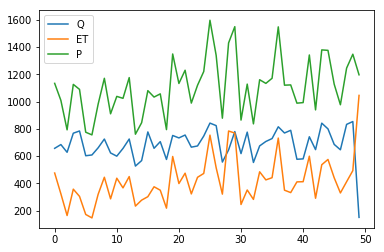

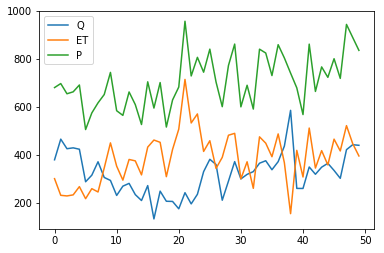

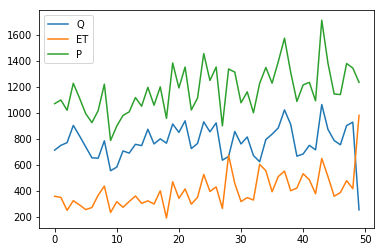

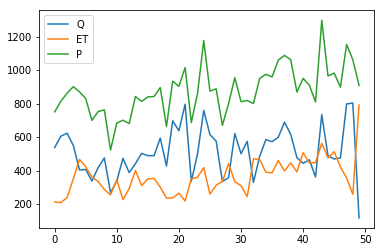

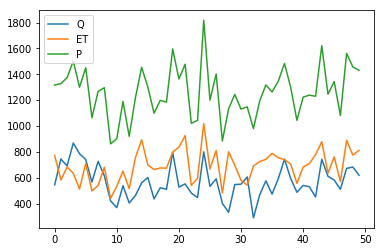

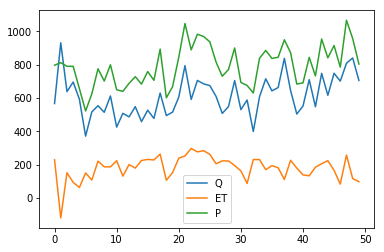

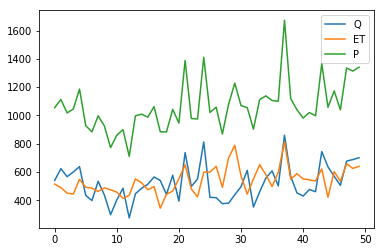

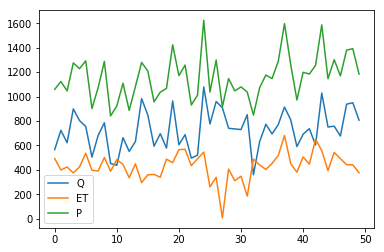

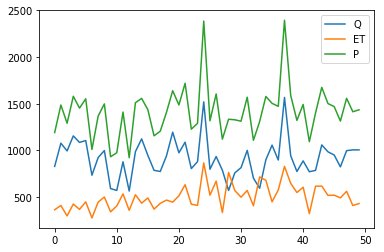

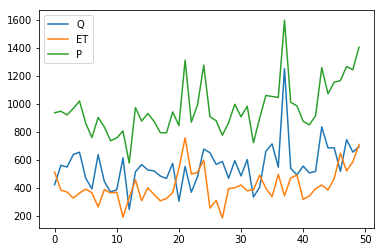

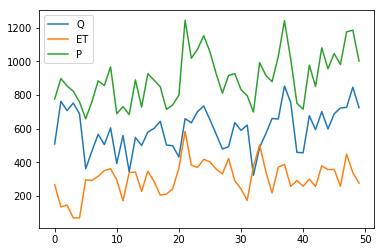

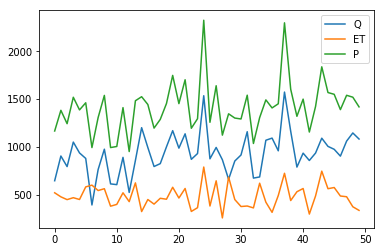

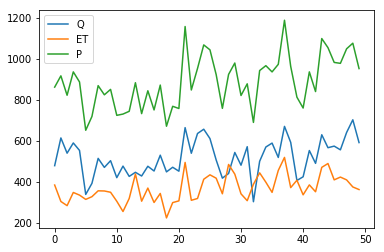

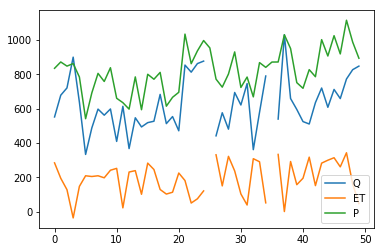

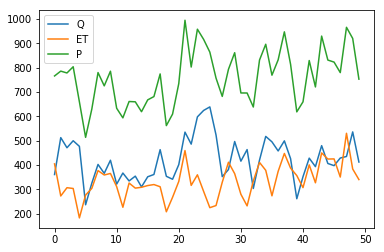

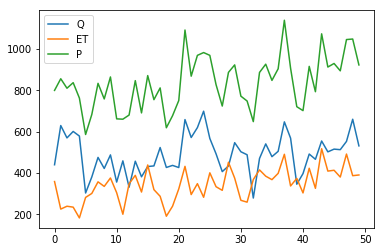

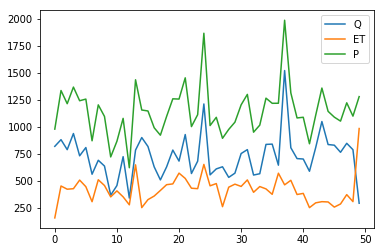

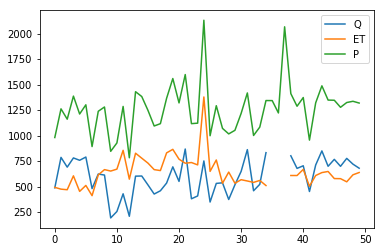

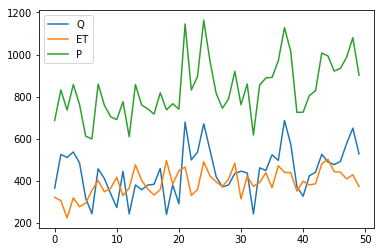

In [42]:
c = ost["final30"][17]
ETann = annualET(ost,years=50)
years=50
for c in ost[f"final{years}"]:
    df = ost["metadata"]
    area = float(df[df.snumber==c].areal)

    runoff = (ost["data"][c]["runoff"].runoff)*(86.4)/area

    Q = annualSum(runoff,years=50)
    try:
        ET = ETann[c]
    except KeyError:
        continue
    snowmelt = annualSum(ost["data"][c]["snow"].qsw,years=50)
    rainfall = annualSum(ost["data"][c]["precip"],years=50)
    
    plt.figure()
    plt.plot(Q,label="Q")
    plt.plot(ET,label="ET")
    plt.plot(snowmelt+rainfall,label="P")
    plt.legend()

### Calculating trends

In [10]:
def prewhitening(ts):
    """
    After Wang&Swail, 2001
    """
    r = stattools.acf(ts,nlags=1,missing="drop")[1]
    pw = ts.copy()
    for i in range(ts.shape[0]-1):
        if i > 0:
            pw[i] = (ts[i] - r*ts[i-1])/(1 - r)
    return pw

In [43]:
def autocorrTest(ts,alpha=0.05):
    acf, qstat, p = stattools.acf(ts,qstat=True,nlags=1)
    ac = acf[1]
    p = p[0]
    sign = p < alpha
    return sign

def annualTrends(data, region, alpha, years=30, end = 2012):

    start = int(end)-years

    catchments = data[f"final{years}"]
    variables = ("runoff","rainfall","snowmelt","evapotranspiration","precipitation")
    meta = data["metadata"]
    ET = annualET(data,years=years)

    df = {}
    df["snumber"] = catchments
    df["regine"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].regine)
    df["main"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].main)
    df["region"] = region
    df["altitude"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].altitude)
    df["lon"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].lon)
    df["lat"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].lat)


    for var in variables:
        trends = []
        for c in catchments:
            if var == "runoff":
                area = (meta[meta.snumber==c].areal).iloc[0]
                ts = (data["data"][c]["runoff"].runoff/area)*((24*6*6)/10)
            elif var == "rainfall":
                ts = data["data"][c]["precip"]
            elif var == "snowmelt":
                ts = data["data"][c]["snow"].qsw
            elif var == "precipitation":
                ts = data["data"][c]["snow"].qsw+data["data"][c]["precip"]
            
            
            annual = annualSum(ts,years,end)
            
            if var == "evapotranspiration":
                try:
                    annual = ET[c]
                except KeyError:
                    trends.append(np.nan)
                    continue
            # autocorrelation testing and prewhitening
            if autocorrTest(annual):
                annual = prewhitening(annual)
            
            # trend detection
            p = trend.mann_kendall(annual)
            
            # significance
            if p < alpha:
                mag = trend.sen_slope(annual)
                trends.append(mag)
            else:
                trends.append(np.nan)
            
        df[var] = trends
    return pd.DataFrame(df)

In [44]:
frames = [annualTrends(ost,"ost",alpha=0.1),
          annualTrends(sor,"sor",alpha=0.1),
          annualTrends(vest,"vest",alpha=0.1),
          annualTrends(trond,"trond",alpha=0.1),
          annualTrends(nord,"nord",alpha=0.1),
          annualTrends(finn,"finn",alpha=0.1)]
annTrends30_10percent = pd.concat(frames)
annTrends30_10percent.reset_index(drop=True,inplace=True)

Glaciation too high for water balance.
Skipping 200268 ...
Glaciation too high for water balance.
Skipping 7600005 ...
Glaciation too high for water balance.
Skipping 4600009 ...
Glaciation too high for water balance.
Skipping 7500022 ...
Glaciation too high for water balance.
Skipping 8800004 ...
Glaciation too high for water balance.
Skipping 7600011 ...
Glaciation too high for water balance.
Skipping 7600010 ...
Glaciation too high for water balance.
Skipping 4600004 ...
Glaciation too high for water balance.
Skipping 7800008 ...
Glaciation too high for water balance.
Skipping 8300007 ...
Glaciation too high for water balance.
Skipping 8600012 ...
Glaciation too high for water balance.
Skipping 8700010 ...
Glaciation too high for water balance.
Skipping 8700002 ...
Glaciation too high for water balance.
Skipping 15900003 ...
Glaciation too high for water balance.
Skipping 15600024 ...
Glaciation too high for water balance.
Skipping 15600013 ...
Glaciation too high for water balance.

In [45]:
frames = [annualTrends(ost,"ost",alpha=0.05),
          annualTrends(sor,"sor",alpha=0.05),
          annualTrends(vest,"vest",alpha=0.05),
          annualTrends(trond,"trond",alpha=0.05),
          annualTrends(nord,"nord",alpha=0.05),
          annualTrends(finn,"finn",alpha=0.05)]
annTrends30_5percent = pd.concat(frames)
annTrends30_5percent.reset_index(drop=True,inplace=True)

Glaciation too high for water balance.
Skipping 200268 ...
Glaciation too high for water balance.
Skipping 7600005 ...
Glaciation too high for water balance.
Skipping 4600009 ...
Glaciation too high for water balance.
Skipping 7500022 ...
Glaciation too high for water balance.
Skipping 8800004 ...
Glaciation too high for water balance.
Skipping 7600011 ...
Glaciation too high for water balance.
Skipping 7600010 ...
Glaciation too high for water balance.
Skipping 4600004 ...
Glaciation too high for water balance.
Skipping 7800008 ...
Glaciation too high for water balance.
Skipping 8300007 ...
Glaciation too high for water balance.
Skipping 8600012 ...
Glaciation too high for water balance.
Skipping 8700010 ...
Glaciation too high for water balance.
Skipping 8700002 ...
Glaciation too high for water balance.
Skipping 15900003 ...
Glaciation too high for water balance.
Skipping 15600024 ...
Glaciation too high for water balance.
Skipping 15600013 ...
Glaciation too high for water balance.

In [46]:
frames = [annualTrends(ost,"ost",years=50,alpha=0.1),
          annualTrends(sor,"sor",years=50,alpha=0.1),
          annualTrends(vest,"vest",years=50,alpha=0.1),
          annualTrends(trond,"trond",years=50,alpha=0.1),
          annualTrends(nord,"nord",years=50,alpha=0.1),
          annualTrends(finn,"finn",years=50,alpha=0.1)]
annTrends50_10percent = pd.concat(frames)
annTrends50_10percent.reset_index(drop=True,inplace=True)

Glaciation too high for water balance.
Skipping 200268 ...
Glaciation too high for water balance.
Skipping 7600005 ...
Glaciation too high for water balance.
Skipping 7500022 ...
Glaciation too high for water balance.
Skipping 8800004 ...
Glaciation too high for water balance.
Skipping 4600004 ...
Glaciation too high for water balance.
Skipping 8700002 ...
Glaciation too high for water balance.
Skipping 15600013 ...
Glaciation too high for water balance.
Skipping 15600008 ...
Glaciation too high for water balance.
Skipping 15600010 ...


In [47]:
frames = [annualTrends(ost,"ost",years=50,alpha=0.05),
          annualTrends(sor,"sor",years=50,alpha=0.05),
          annualTrends(vest,"vest",years=50,alpha=0.05),
          annualTrends(trond,"trond",years=50,alpha=0.05),
          annualTrends(nord,"nord",years=50,alpha=0.05),
          annualTrends(finn,"finn",years=50,alpha=0.05)]
annTrends50_5percent = pd.concat(frames)
annTrends50_5percent.reset_index(drop=True,inplace=True)

Glaciation too high for water balance.
Skipping 200268 ...
Glaciation too high for water balance.
Skipping 7600005 ...
Glaciation too high for water balance.
Skipping 7500022 ...
Glaciation too high for water balance.
Skipping 8800004 ...
Glaciation too high for water balance.
Skipping 4600004 ...
Glaciation too high for water balance.
Skipping 8700002 ...
Glaciation too high for water balance.
Skipping 15600013 ...
Glaciation too high for water balance.
Skipping 15600008 ...
Glaciation too high for water balance.
Skipping 15600010 ...


In [49]:
annTrends30_10percent.to_csv("annualTrends_30years_a10.csv",index=False)
annTrends30_5percent.to_csv("annualTrends_30years_a5.csv",index=False)
annTrends50_10percent.to_csv("annualTrends_50years_a10.csv",index=False)
annTrends50_5percent.to_csv("annualTrends_50years_a5.csv",index=False)


## Calculating T trends

In [50]:
def Tmean(temp,endYear=2012,years=30):
    """
    Parameters
    ----------
    temp: pandas.DataFrame
        table with runoff column and datetime as index
    endYear: int
    years: int
        number of years in analysis period ending with endYear
        
    Returns
    -------
    pandas of mean annual temperature
    """
    startYear = endYear - years + 1
    start = str(startYear)
    end = str(endYear)
    t = temp[start:end]
    TmeanYear = t.groupby(t.index.year).mean()
    TmeanYear.replace(0.,np.nan, inplace=True)
    return np.array(TmeanYear)

In [51]:
def annualTempTrends(data, region, alpha, years=30, end = 2012):

    catchments = data[f"final{years}"]
    var = "Ttrend_deg/yr"
    meta = data["metadata"]

    df = {}
    df["snumber"] = catchments
    df["regine"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].regine)
    df["main"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].main)
    df["region"] = region
    df["altitude"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].altitude)
    df["lon"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].lon)
    df["lat"] = np.array(meta[meta.snumber.isin(data[f"final{years}"])].lat)


    trends = []
    for c in catchments:
        ts = data["data"][c]["temp"]
        annual = Tmean(ts,endYear=end,years=years)

        # autocorrelation testing and prewhitening
        if autocorrTest(annual):
            annual = prewhitening(annual)

        # trend detection
        p = trend.mann_kendall(annual)

        # significance
        if p < alpha:
            mag = trend.sen_slope(annual)
            trends.append(mag)
        else:
            trends.append(np.nan)
    df[var] = trends
    return pd.DataFrame(df)

In [52]:
frames = [annualTempTrends(finn,"finn",alpha=0.1),
          annualTempTrends(nord,"nord",alpha=0.1),
          annualTempTrends(trond,"trond",alpha=0.1),
          annualTempTrends(vest,"vest",alpha=0.1),
          annualTempTrends(ost,"ost",alpha=0.1),
          annualTempTrends(sor,"sor",alpha=0.1)]
annTempTrends30_10percent = pd.concat(frames)
annTempTrends30_10percent.reset_index(drop=True,inplace=True)

In [53]:
frames = [annualTempTrends(finn,"finn",alpha=0.05),
          annualTempTrends(nord,"nord",alpha=0.05),
          annualTempTrends(trond,"trond",alpha=0.05),
          annualTempTrends(vest,"vest",alpha=0.05),
          annualTempTrends(ost,"ost",alpha=0.05),
          annualTempTrends(sor,"sor",alpha=0.05)]
annTempTrends30_5percent = pd.concat(frames)
annTempTrends30_5percent.reset_index(drop=True,inplace=True)

In [54]:
frames = [annualTempTrends(finn,"finn",years=50,alpha=0.1),
          annualTempTrends(nord,"nord",years=50,alpha=0.1),
          annualTempTrends(trond,"trond",years=50,alpha=0.1),
          annualTempTrends(vest,"vest",years=50,alpha=0.1),
          annualTempTrends(ost,"ost",years=50,alpha=0.1),
          annualTempTrends(sor,"sor",years=50,alpha=0.1)]
annTempTrends50_10percent = pd.concat(frames)
annTempTrends50_10percent.reset_index(drop=True,inplace=True)

In [55]:
frames = [annualTempTrends(finn,"finn",years=50,alpha=0.05),
          annualTempTrends(nord,"nord",years=50,alpha=0.05),
          annualTempTrends(trond,"trond",years=50,alpha=0.05),
          annualTempTrends(vest,"vest",years=50,alpha=0.05),
          annualTempTrends(ost,"ost",years=50,alpha=0.05),
          annualTempTrends(sor,"sor",years=50,alpha=0.05)]
annTempTrends50_5percent = pd.concat(frames)
annTempTrends50_5percent.reset_index(drop=True,inplace=True)

In [56]:
annTempTrends30_10percent.to_csv("annualTempTrends_30years_a10.csv",index=False)
annTempTrends50_10percent.to_csv("annualTempTrends_50years_a10.csv",index=False)
annTempTrends30_5percent.to_csv("annualTempTrends_30years_a5.csv",index=False)
annTempTrends50_5percent.to_csv("annualTempTrends_50years_a5.csv",index=False)

# Plotting

## Hydrological trend maps

In [57]:
def getLocations(df):
    regine = list(df.regine)
    main = list(df.main)
    final = []
    for i in range(len(regine)):
        final.append(f"{str(regine[i])}.{str(main[i])}")

    mask = stations.STASJON_NR.isin(final)
    selected = stations[mask]
    return selected

In [58]:
def getAllLoc(df10,df5,variable="streamflow"):
    pos10 = df10[df10[variable]>0]
    pos5 = df5[df5[variable]>0]

    neg10 = df10[df10[variable]<0]
    neg5 = df5[df5[variable]<0]

    rest = df10[df10[variable].isnull()]
    
    return getLocations(pos10),getLocations(pos5),getLocations(rest),getLocations(neg5),getLocations(neg10)

In [59]:
def plotAnnualTrends(pos10, pos5, no, neg5, neg10, var, filename, legend = False):
    fig,ax = plt.subplots(figsize=(30,10))
    norge.plot(ax=ax,color="white", edgecolor="lightgrey")
    regionLines.plot(ax=ax,color="darksalmon",label="Runoff region borders")
    no.plot(ax=ax,marker=".",markersize=20,color="grey",label="No significant trend",alpha=.5)
    pos10.plot(ax=ax,marker="o",markersize=40,color="lightblue",label="Weak positive",alpha=1)
    pos5.plot(ax=ax,marker="o",markersize=50,color="b",label="Strong positive",alpha=1)
    neg10.plot(ax=ax,marker="o",markersize=40,color="pink",label="Weak negative",alpha=1)
    neg5.plot(ax=ax,marker="o",markersize=50,color="red",label="Strong negative",alpha=1)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklines(), visible=False)
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax.spines.values(), visible=False)
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [0,3,2,1,4,5]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="upper left")
    plt.title(var.upper())
    plt.savefig(f"Plots/Annual/annualTrends_{filename}.png",dpi=400,bbox_inches='tight')

/Users/skam2905/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
/Users/skam2905/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


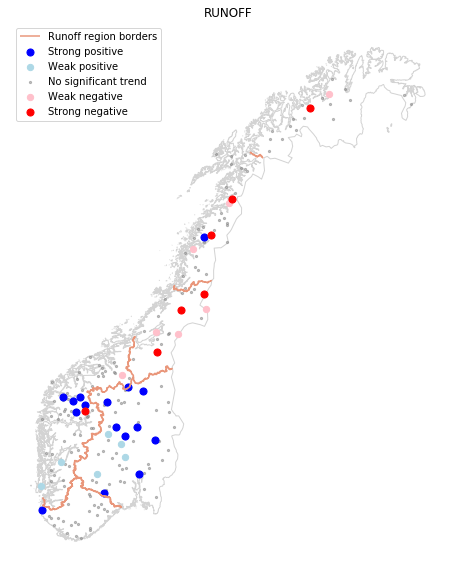

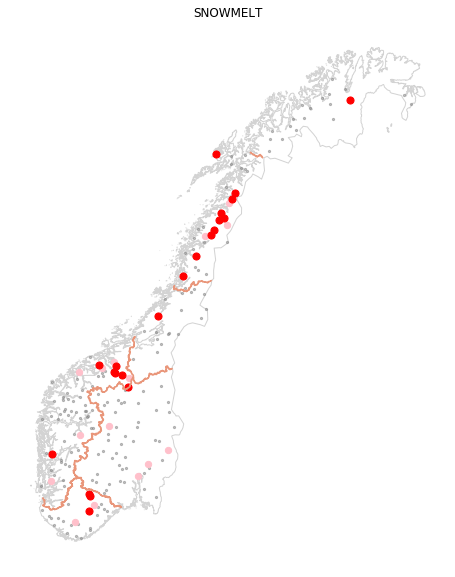

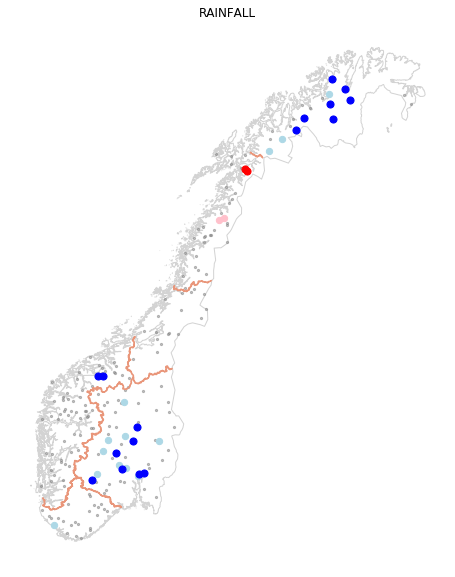

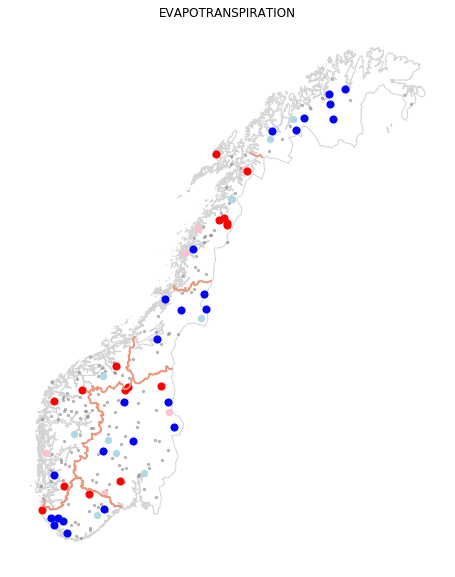

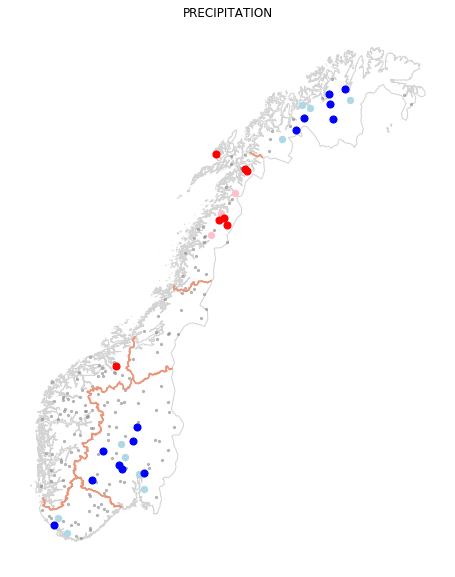

In [60]:
for var in ["runoff","snowmelt","rainfall","evapotranspiration","precipitation"]:
    pos10, pos5, no, neg5, neg10 = getAllLoc(df10=annTrends30_10percent,df5=annTrends30_5percent,variable=var)
    if var == "runoff":
        plotAnnualTrends(pos10, pos5, no, neg5, neg10, var, f"{var}_30year",legend = True)
    else:
        plotAnnualTrends(pos10, pos5, no, neg5, neg10, var, f"{var}_30year")

/Users/skam2905/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:418: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


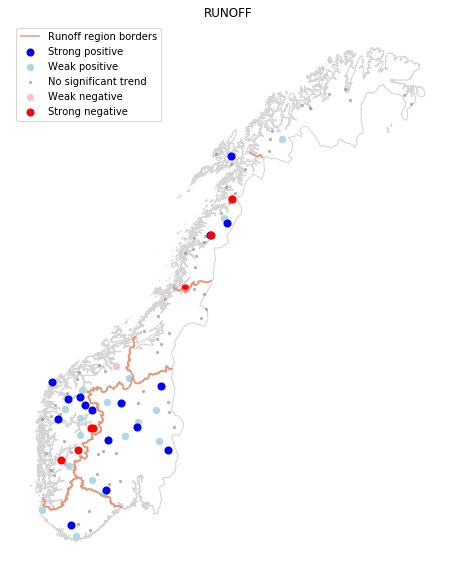

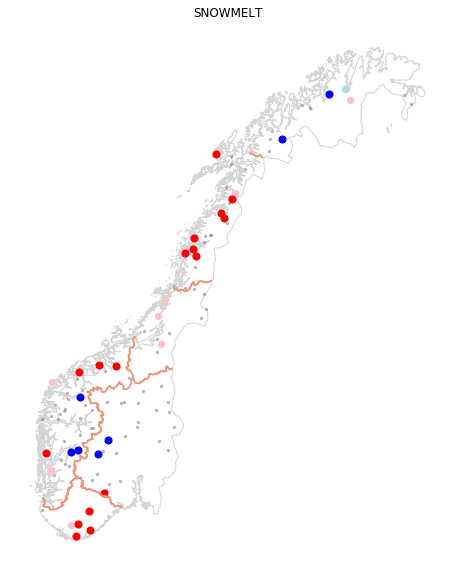

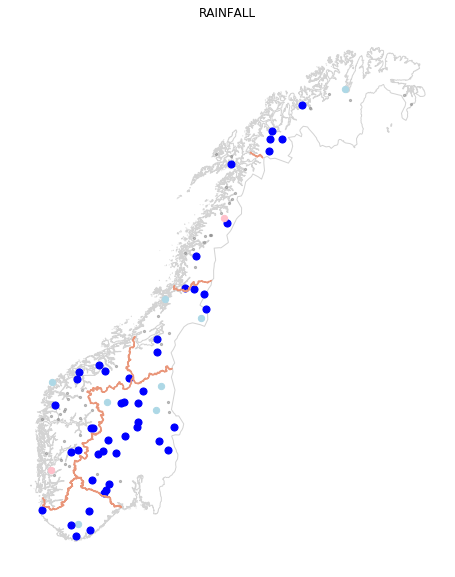

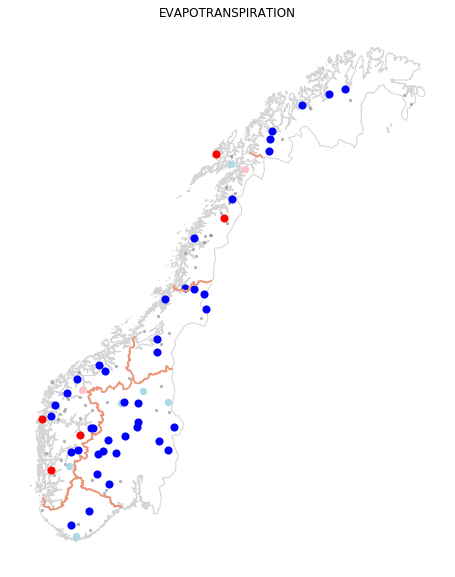

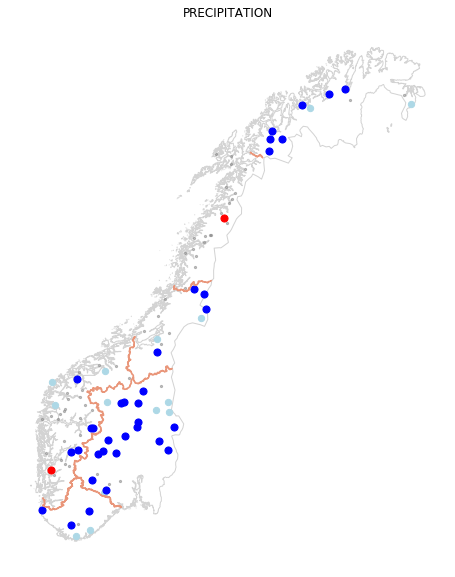

In [61]:
for var in ["runoff","snowmelt","rainfall","evapotranspiration","precipitation"]:
    pos10, pos5, no, neg5, neg10 = getAllLoc(df10=annTrends50_10percent,df5=annTrends50_5percent,variable=var)
    if var == "runoff":
        plotAnnualTrends(pos10, pos5, no, neg5, neg10, var, f"{var}_50year",legend = True)
    else:
        plotAnnualTrends(pos10, pos5, no, neg5, neg10, var, f"{var}_50year")

## Scatterplots

/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


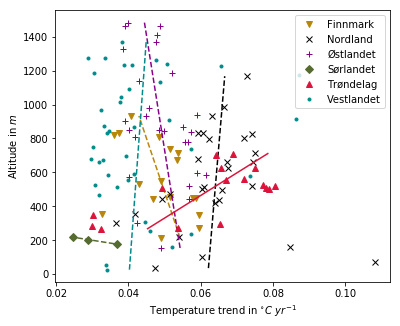

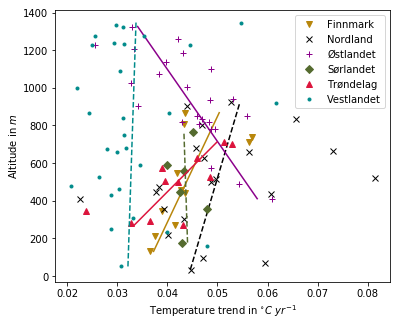

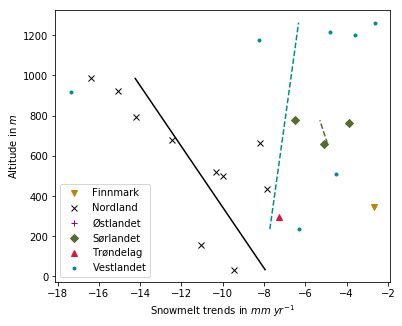

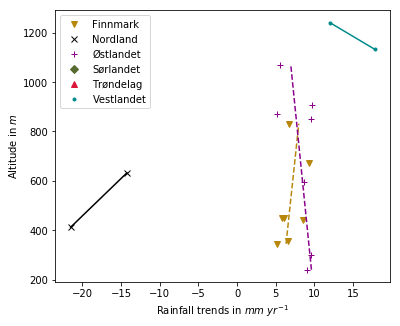

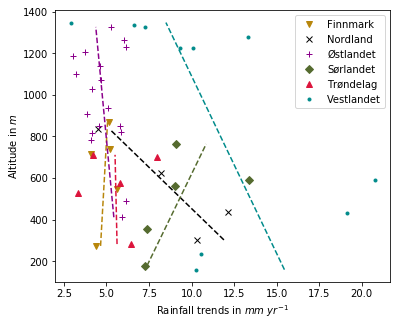

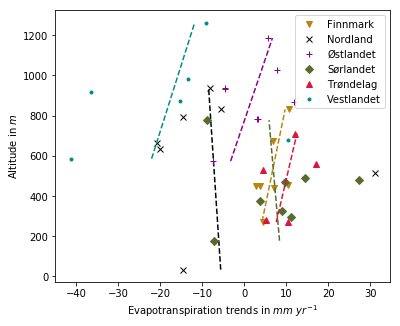

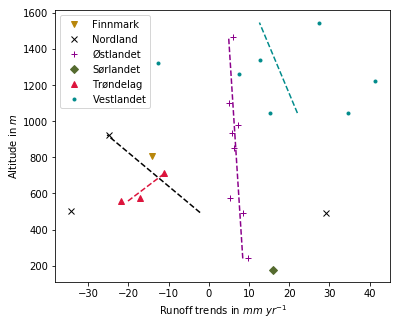

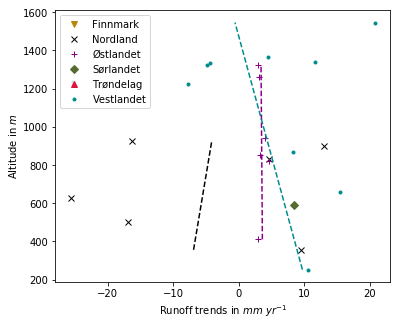

In [62]:
regionLabels = {"ost":"Østlandet",
                "vest":"Vestlandet",
                "nord":"Nordland",
                "finn":"Finnmark",
                "trond":"Trøndelag",
                "sor":"Sørlandet"}
marker = itertools.cycle(("v", "x", "+", "D", "^","."))
color = itertools.cycle(("darkgoldenrod","black","darkmagenta","darkolivegreen","crimson","darkcyan"))

def scatterplotTrendAll(df,years,
                        column="Ttrend_deg/yr",
                        variable="temperature",
                        xlabel="Temperature trend in $^{\circ} C \ yr^{-1}$"):
    plt.figure(figsize=(6,5))
    for label, dfr in df.groupby("region"):
        col = next(color)
        plt.plot(dfr[column],dfr.altitude,".",marker=next(marker),color=col,label=regionLabels[label])
        x = dfr[column]
        y = dfr.altitude
        mask = np.isfinite(x)
        if x[mask].empty:
            continue
        reg = stats.linregress(y[mask],x[mask])
        if reg.pvalue < 0.05:
            xx = np.linspace(np.nanmin(y[mask]),np.nanmax(y[mask]))
            plt.plot(reg.slope*xx+reg.intercept,xx,color=col)
        else:
            xx = np.linspace(np.nanmin(y[mask]),np.nanmax(y[mask]))
            plt.plot(reg.slope*xx+reg.intercept,xx,"--",color=col)
    plt.legend()

    plt.ylabel("Altitude in $m$")
    plt.xlabel(xlabel)

    plt.savefig(f"Plots/Annual/{variable}Trends_{years}year.png",dpi=400,bbox_inches='tight')

scatterplotTrendAll(annTempTrends30_5percent,30)
scatterplotTrendAll(annTempTrends50_5percent,50)
scatterplotTrendAll(annTrends30_5percent,30,column="snowmelt",variable="snowmelt",xlabel="Snowmelt trends in $mm \ yr^{-1}$")
scatterplotTrendAll(annTrends30_5percent,30,column="rainfall",variable="rainfall",xlabel="Rainfall trends in $mm \ yr^{-1}$")
scatterplotTrendAll(annTrends50_5percent,50,column="rainfall",variable="rainfall",xlabel="Rainfall trends in $mm \ yr^{-1}$")
scatterplotTrendAll(annTrends30_5percent,30,column="evapotranspiration",variable="evapotranspiration",xlabel="Evapotranspiration trends in $mm \ yr^{-1}$")
scatterplotTrendAll(annTrends30_5percent,30,column="runoff",variable="runoff",xlabel="Runoff trends in $mm \ yr^{-1}$")
scatterplotTrendAll(annTrends50_5percent,50,column="runoff",variable="runoff",xlabel="Runoff trends in $mm \ yr^{-1}$")

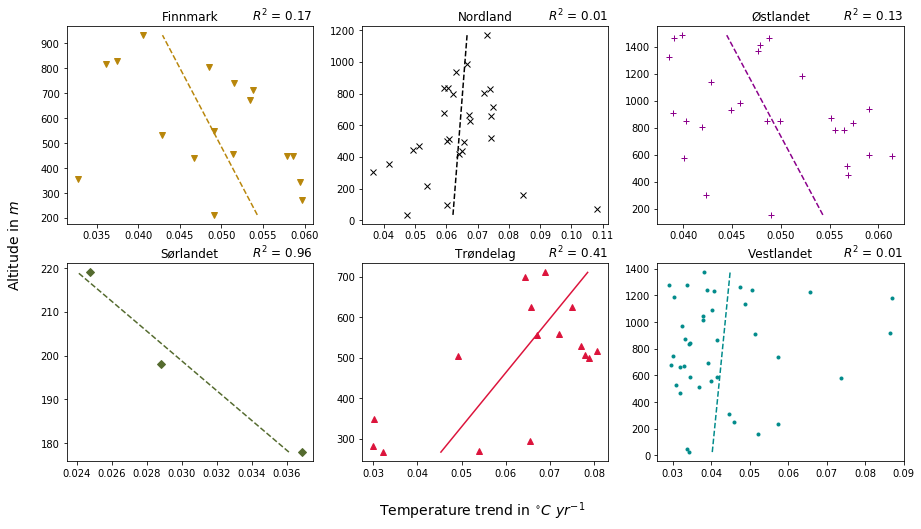

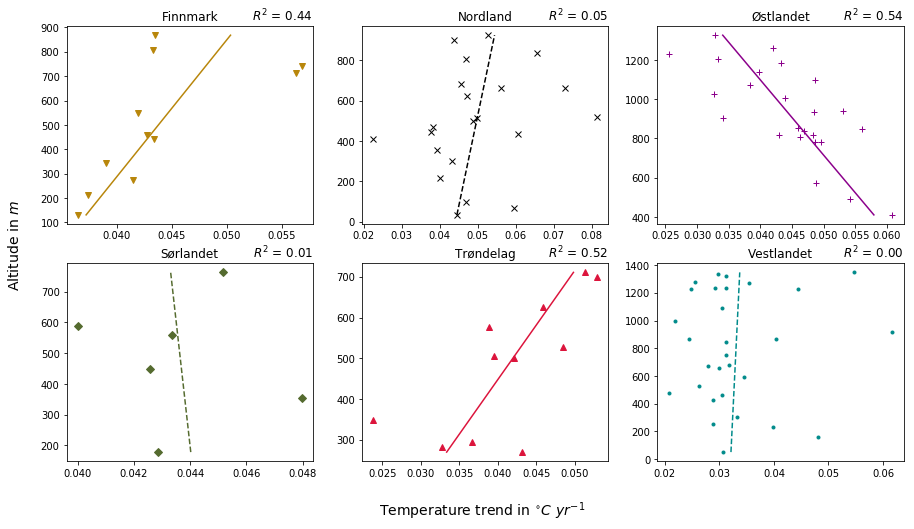

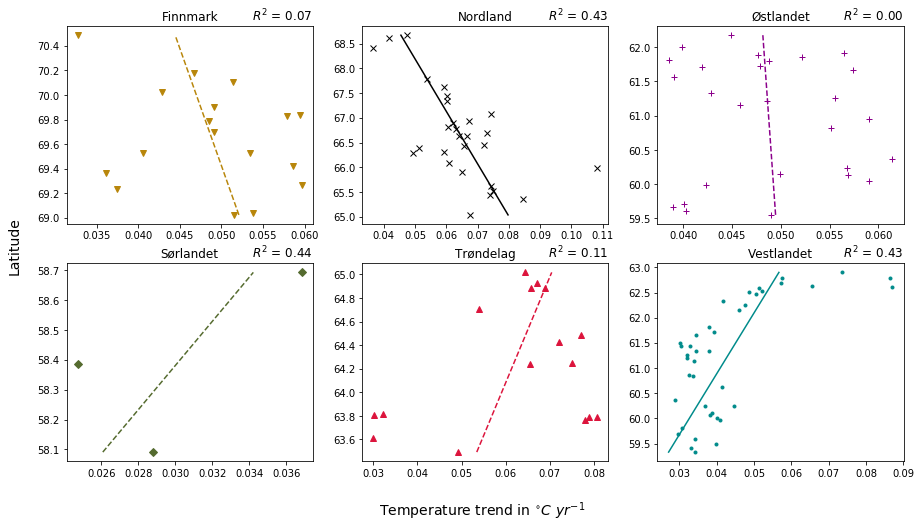

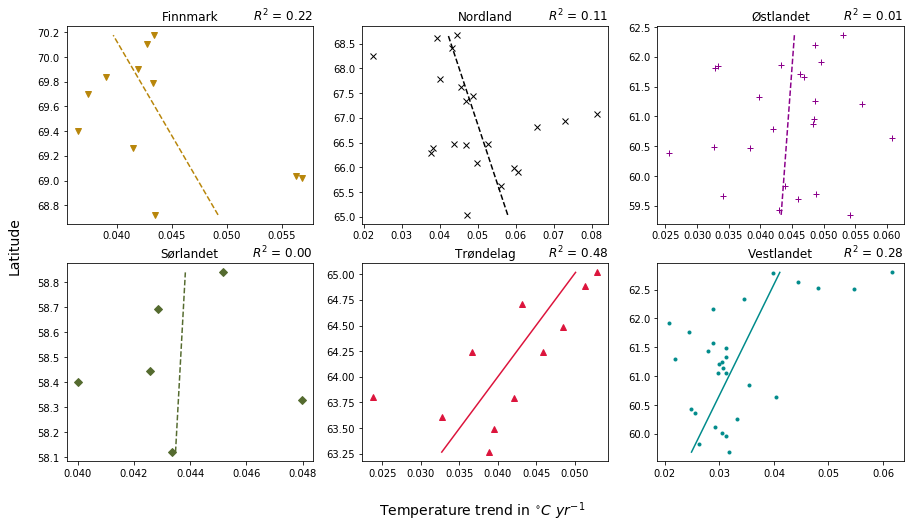

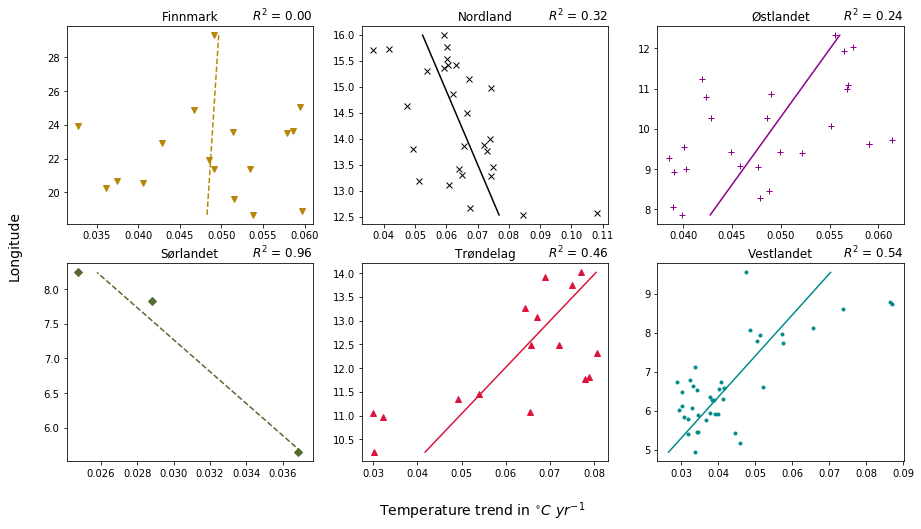

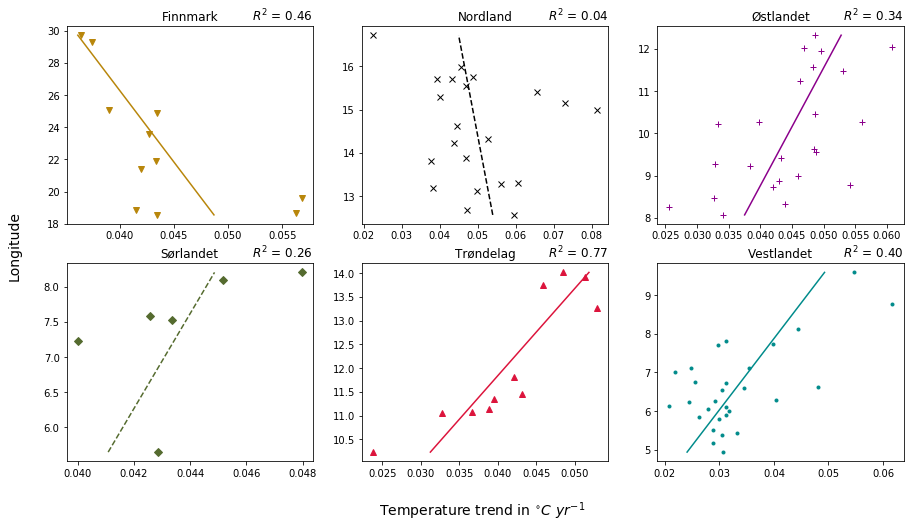

In [63]:
def scatterplotTrends(df,
                      years,
                      column="Ttrend_deg/yr",
                      variable="temperature",
                      xlabel="Temperature trend in $^{\circ} C \ yr^{-1}$",
                      correlateWith="altitude"):
    fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,8))
    axes = itertools.cycle((ax[0][0],ax[0][1],ax[0][2],ax[1][0],ax[1][1],ax[1][2]))

    for label, dfr in df.groupby("region"):
        col = next(color)
        a = next(axes)
        
        x = np.array(dfr[column])
        if x.size == 0:
            continue
        
        if correlateWith == "altitude":
            y = np.array(dfr.altitude)
        elif correlateWith == "latitude":
            y = np.array(dfr.lat)
        elif correlateWith == "longitude":
            y = np.array(dfr.lon)

        a.plot(x,y,".",marker=next(marker),color=col,label=regionLabels[label])
        
        mask = np.isfinite(x)
        if x[mask].size == 0:
            continue
        reg = stats.linregress(y[mask],x[mask])
        if reg.pvalue < 0.05:
            xx = np.linspace(np.nanmin(y[mask]),np.nanmax(y[mask]))
            a.plot(reg.slope*xx+reg.intercept,xx,color=col)
        else:
            xx = np.linspace(np.nanmin(y[mask]),np.nanmax(y[mask]))
            a.plot(reg.slope*xx+reg.intercept,xx,"--",color=col)
        a.set_title(f"{regionLabels[label]}")
        a.set_title(f"$R^2$ = {reg.rvalue**2:.2f}",loc="right")
   
    if correlateWith == "altitude":
        fig.text(0.07, 0.5, "Altitude in $m$", va="center", rotation="vertical",fontsize=14)
    elif correlateWith == "latitude":
        fig.text(0.07, 0.5, "Latitude", va="center", rotation="vertical",fontsize=14)
    elif correlateWith == "longitude":
        fig.text(0.07, 0.5, "Longitude", va="center", rotation="vertical",fontsize=14)
    
    fig.text(0.51, 0.03, xlabel, ha="center",fontsize=14)
    
    plt.savefig(f"Plots/Annual/{variable}Trends_{correlateWith}_regions_{years}year.png",dpi=400,bbox_inches='tight')

scatterplotTrends(annTempTrends30_5percent,30)
scatterplotTrends(annTempTrends50_5percent,50)
scatterplotTrends(annTempTrends30_5percent,30,correlateWith="latitude")
scatterplotTrends(annTempTrends50_5percent,50,correlateWith="latitude")
scatterplotTrends(annTempTrends30_5percent,30,correlateWith="longitude")
scatterplotTrends(annTempTrends50_5percent,50,correlateWith="longitude")

/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


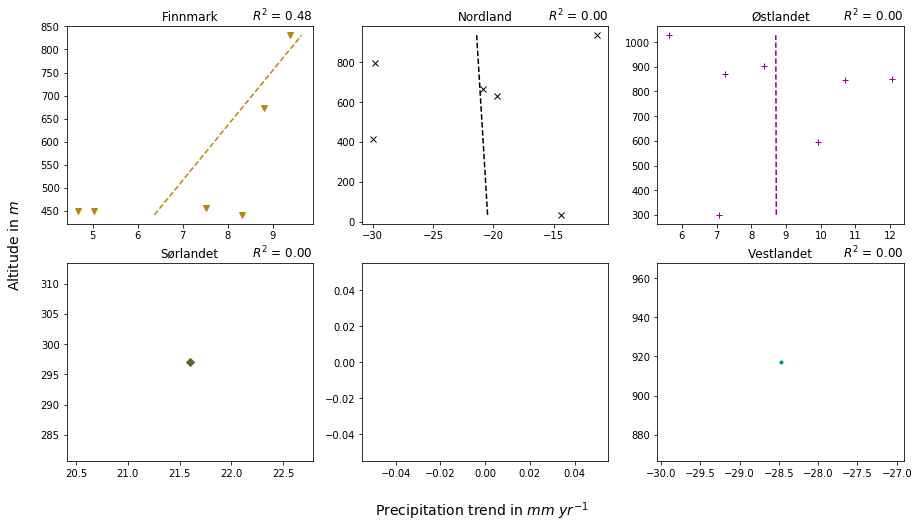

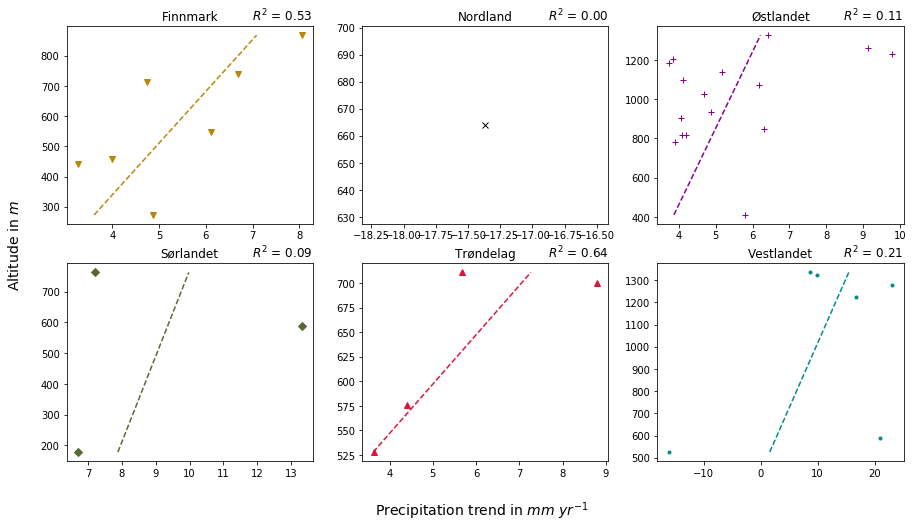

In [64]:
scatterplotTrends(annTrends30_5percent,30,
                  column="precipitation",
                  variable="precipitation",
                  xlabel="Precipitation trend in $mm \ yr^{-1}$")
scatterplotTrends(annTrends50_5percent,50,
                  column="precipitation",
                  variable="precipitation",
                  xlabel="Precipitation trend in $mm \ yr^{-1}$")

/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


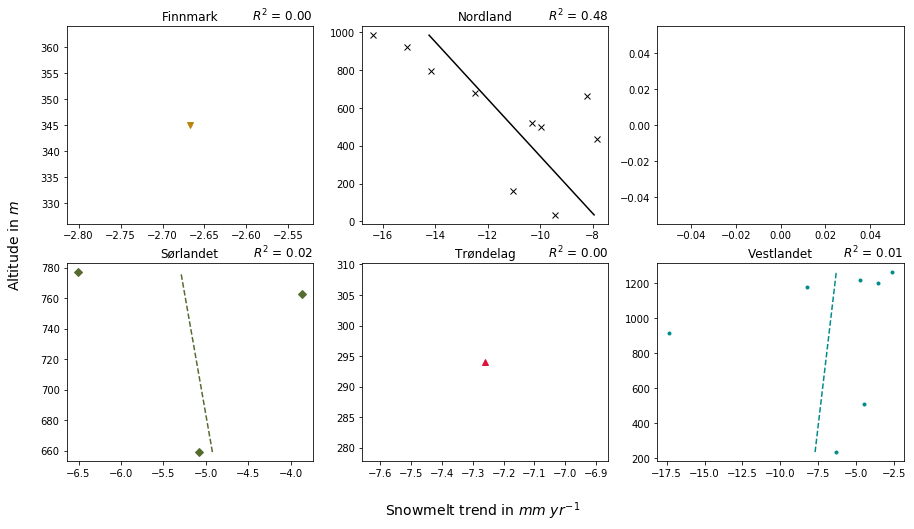

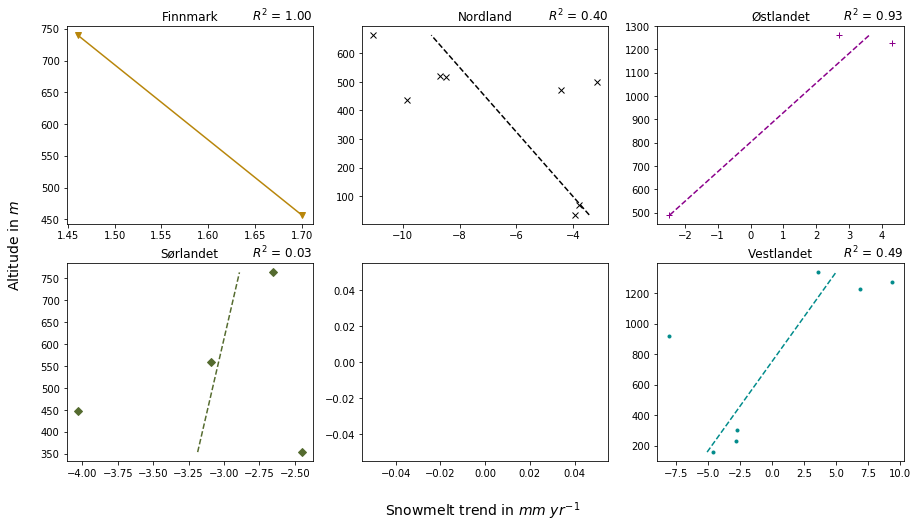

In [65]:
scatterplotTrends(annTrends30_5percent,30,
                  column="snowmelt",
                  variable="snowmelt",
                  xlabel="Snowmelt trend in $mm \ yr^{-1}$")
scatterplotTrends(annTrends50_5percent,50,
                  column="snowmelt",
                  variable="snowmelt",
                  xlabel="Snowmelt trend in $mm \ yr^{-1}$")

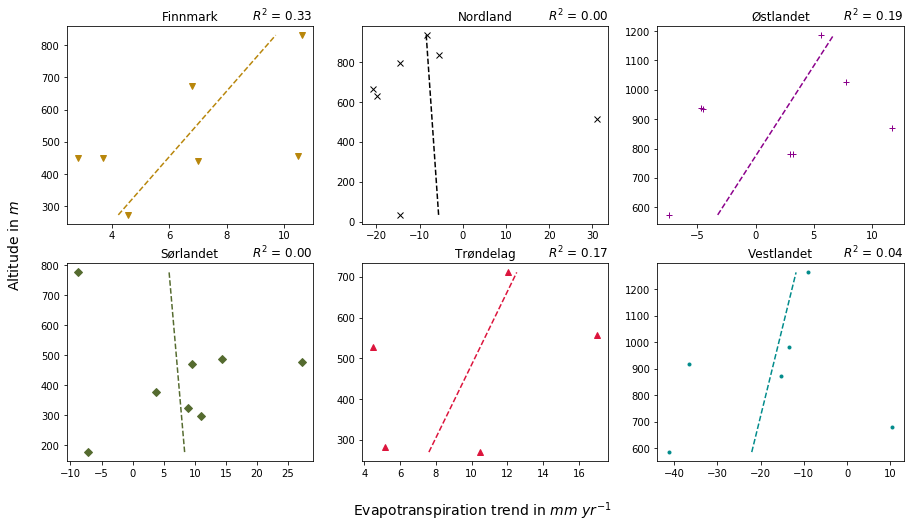

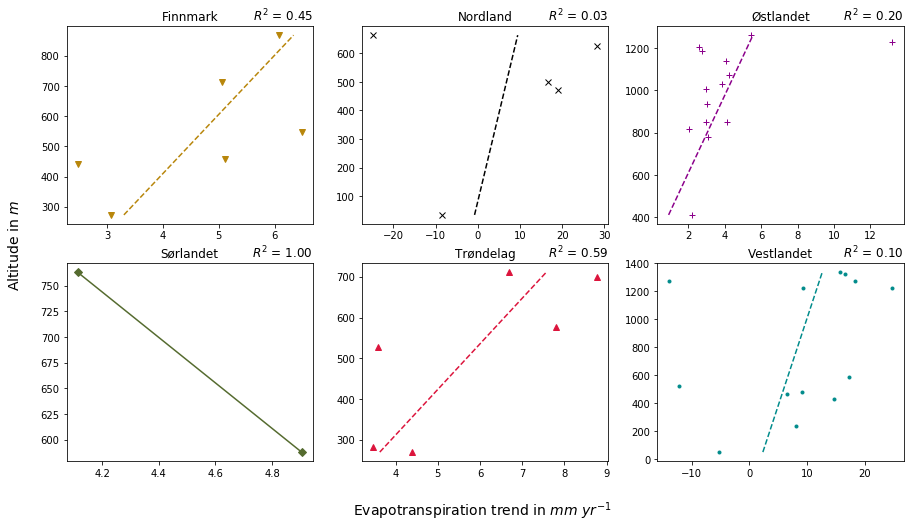

In [66]:
scatterplotTrends(annTrends30_5percent,30,
                  column="evapotranspiration",
                  variable="evapotranspiration",
                  xlabel="Evapotranspiration trend in $mm \ yr^{-1}$")
scatterplotTrends(annTrends50_5percent,50,
                  column="evapotranspiration",
                  variable="evapotranspiration",
                  xlabel="Evapotranspiration trend in $mm \ yr^{-1}$")

/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/skam2905/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


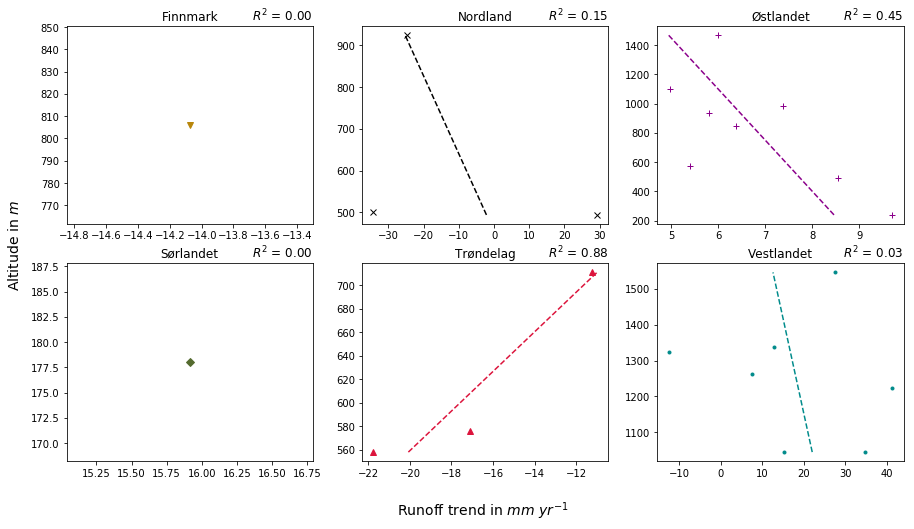

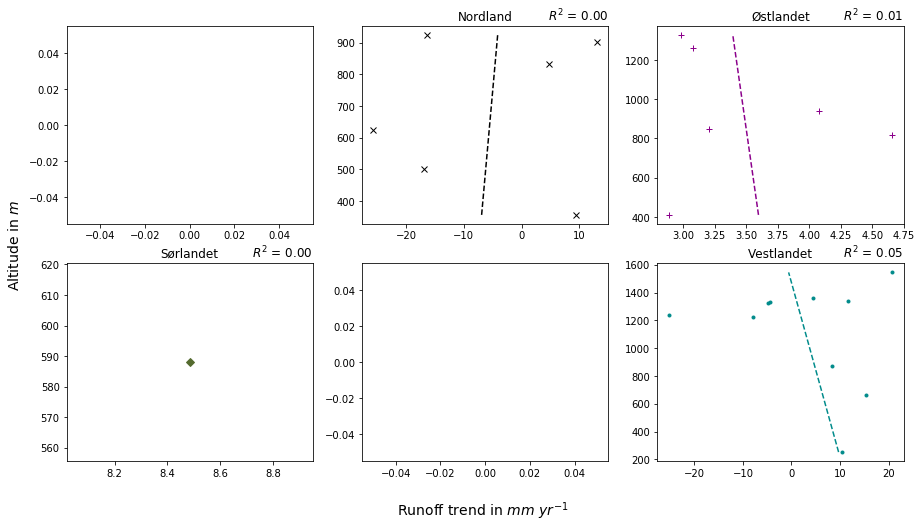

In [67]:
scatterplotTrends(annTrends30_5percent,30,
                  column="runoff",
                  variable="runoff",
                  xlabel="Runoff trend in $mm \ yr^{-1}$")
scatterplotTrends(annTrends50_5percent,50,
                  column="runoff",
                  variable="runoff",
                  xlabel="Runoff trend in $mm \ yr^{-1}$")

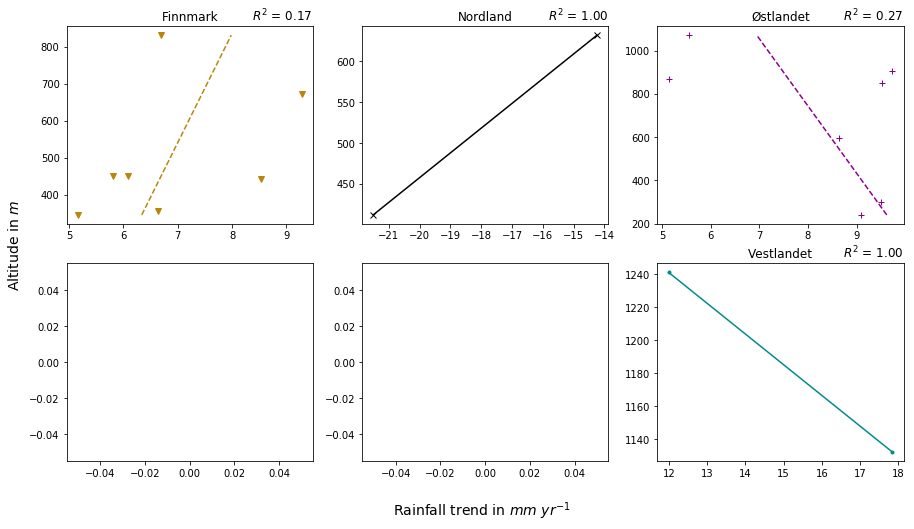

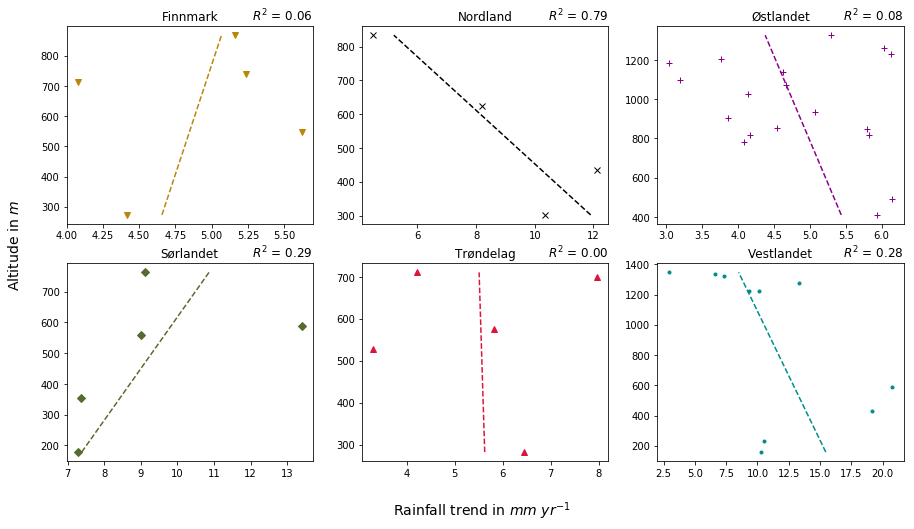

In [68]:
scatterplotTrends(annTrends30_5percent,30,
                  column="rainfall",
                  variable="rainfall",
                  xlabel="Rainfall trend in $mm \ yr^{-1}$")
scatterplotTrends(annTrends50_5percent,50,
                  column="rainfall",
                  variable="rainfall",
                  xlabel="Rainfall trend in $mm \ yr^{-1}$")

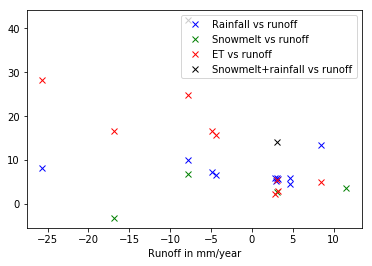

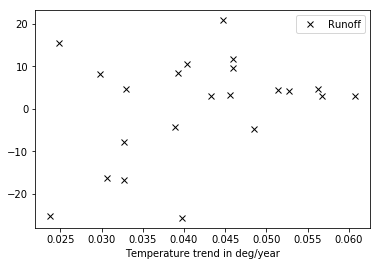

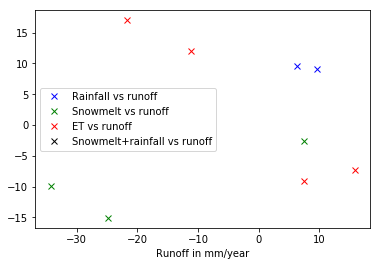

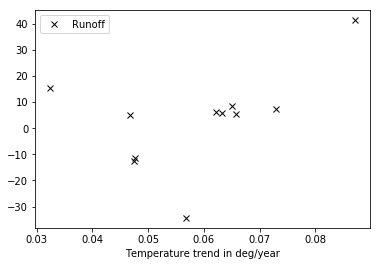

In [69]:
def plotAnnualScatter(df,temp):
    runoff = np.array(df.runoff)
    rain = np.array(df.rainfall)
    snow = np.array(df.snowmelt)
    evapo = np.array(df.evapotranspiration)
    T = temp["Ttrend_deg/yr"]
    
    plt.figure()
    plt.plot(runoff,rain,"bx",label="Rainfall vs runoff")
    plt.plot(runoff,snow,"gx",label="Snowmelt vs runoff")
    plt.plot(runoff,evapo,"rx",label="ET vs runoff")
    plt.plot(runoff,snow+rain+evapo,"kx",label="Snowmelt+rainfall vs runoff")
    plt.legend()
    plt.xlabel("Runoff in mm/year")
    
    plt.figure()
    plt.plot(T,runoff,"kx",label="Runoff")
    #plt.plot(T,rain,"bx",label="Rainfall")
    #plt.plot(T,snow,"gx",label="Snowmelt")
    #plt.plot(T,evapo,"rx",label="ET")
    plt.legend()
    plt.xlabel("Temperature trend in deg/year")

plotAnnualScatter(annTrends50_5percent,annTempTrends50_5percent)
plotAnnualScatter(annTrends30_5percent,annTempTrends30_5percent)
#plotAnnualScatter(annTrends50_10percent,annTempTrends50_10percent)
#plotAnnualScatter(annTrends30_10percent,annTempTrends30_10percent)

## Barplots

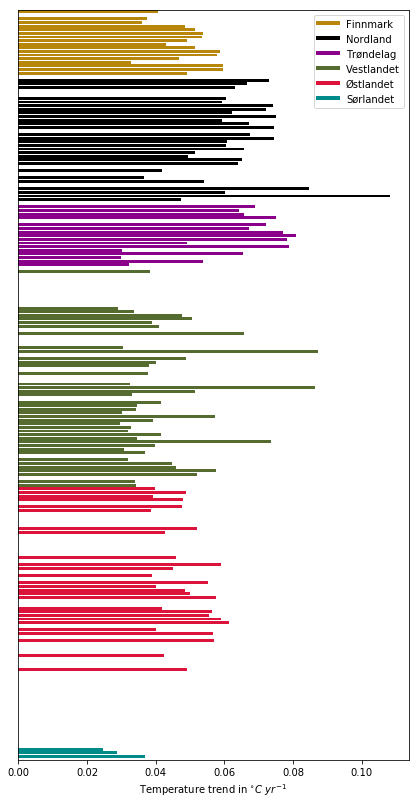

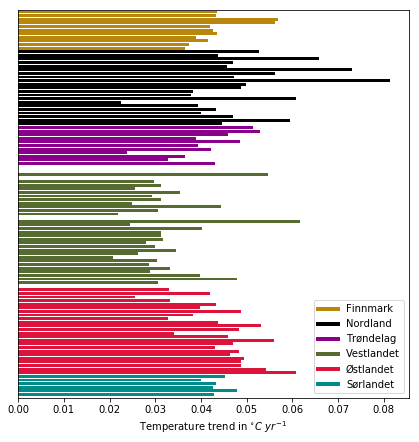

In [70]:
colors = {"finn":"darkgoldenrod",
          "nord":"black",
          "trond":"darkmagenta",
          "vest":"darkolivegreen",
          "ost":"crimson",
          "sor":"darkcyan"}

def barplotTempTrends(df,years):
    size = df.shape[0]/15
    plt.figure(figsize=(7,size))
    for i in df.index:
        plt.barh(i,df["Ttrend_deg/yr"].iloc[i],color=colors[df.region.iloc[i]])
    plt.ylim(-0.5,df.shape[0])
    plt.xlabel("Temperature trend in $^{\circ} C \ yr^{-1}$")
    plt.gca().invert_yaxis()
    
    loc = np.arange(0,df.shape[0])
    alt = np.array(df.snumber).astype(int)
    plt.yticks(loc,alt,fontsize=6)
    plt.yticks([],[])
    
    col = list(colors.values())
    region = list(colors.keys())
    
    legend_elements = [Line2D([0], [0], color=col[0], lw=4, label=regionLabels[region[0]]),
                       Line2D([0], [0], color=col[1], lw=4, label=regionLabels[region[1]]),
                       Line2D([0], [0], color=col[2], lw=4, label=regionLabels[region[2]]),
                       Line2D([0], [0], color=col[3], lw=4, label=regionLabels[region[3]]),
                       Line2D([0], [0], color=col[4], lw=4, label=regionLabels[region[4]]),
                       Line2D([0], [0], color=col[5], lw=4, label=regionLabels[region[5]])]
    plt.legend(handles=legend_elements)
    
    plt.savefig(f"Plots/temperatureTrends_barplot_{years}year.png",dpi=400,bbox_inches='tight')

barplotTempTrends(annTempTrends30_5percent,30)
barplotTempTrends(annTempTrends50_5percent,50)

# Field significance

## Making annual dataframe

In [71]:
def annualAllVariables(data, years = 30):
    """
    Calculates annual data from daily data for runoff, rainfall, snowmelt, precipitation, and evapotraspiration.
    Evapotranspiration is calculated using the water balance equation, and assumes changes in annual storage is zero.
    """
    df = data["metadata"]
    evapo = {}
    runoff = {}
    rain = {}
    snow = {}
    precip = {}
    for c in data[f"final{years}"]:
        area = (df[df.snumber==c].areal).iloc[0]
        Q = annualSum((data["data"][c]["runoff"].runoff)*(86.4)/area,years=years)
        rainfall = annualSum(data["data"][c]["precip"],years=years)
        snowmelt = annualSum(data["data"][c]["snow"].qsw,years=years)
        P = rainfall + snowmelt
        ET = P - Q
        evapo[c] = ET
        runoff[c] = Q
        rain[c] = rainfall
        snow[c] = snowmelt
        precip[c] = P
    years = range(2013-years,2013)
    return pd.DataFrame(evapo,index=years),pd.DataFrame(runoff,index=years),pd.DataFrame(rain,index=years),pd.DataFrame(snow,index=years),pd.DataFrame(precip,index=years)

## Calculating field significance

In [72]:
def resampling(df,years):
    """
    Resampling procedure after Burn and Hag Elnur, 2002.
    """
    years = np.arange(2013-years,2013)
    ## bootstrap procedure
    resampled = {}
    catchments = list(df.columns)

    for c in catchments:
        ts = []
        for i in range(len(years)):
            # select random year
            year = np.random.choice(years)
            # get values for that year
            resampled[i] = np.array(df.loc[year])

    return pd.DataFrame.from_dict(resampled,columns=catchments,orient="index")

In [73]:
def fieldSign(df, years, alpha = 0.05, q = 90, NS = 500, histogram=False):
    """
    Calculating the field significance after Burn and Hag Elnur, 2002.
    """
    catchments = list(df.columns)
    
    sign = []
    for i in range(NS):
        resampled = resampling(df,years=years)
        s = 0
        for col in catchments:
            ts = np.array(resampled[col])
            p = trend.mann_kendall(ts)
            if p<alpha:
                s += 1
        sign.append(s/len(catchments))

    distribution = np.array(sign)
    pcrit = np.percentile(distribution,q)
    
    # plot histogram
    if histogram:
        plt.figure(figsize=(6,5))
        n,bins,patches = plt.hist(distribution,edgecolor="k", linewidth=1, alpha = 0.8)
        plt.xlabel("% of catchments with significant trends",fontsize=14)
        plt.ylabel("Frequency",fontsize=14)
        plt.vlines(pcrit,0,NS,color="r")
        plt.ylim(0,n.max()+10)
    
    s = 0
    for col in catchments:
        ts = np.array(df[col])
        p = trend.mann_kendall(ts)
        if p<alpha:
            s += 1
    percentSign = s/len(catchments)
    
    return pcrit, percentSign, percentSign>pcrit

In [74]:
evapo,runoff,rain,snow,precip = annualAllVariables(vest,years=30)

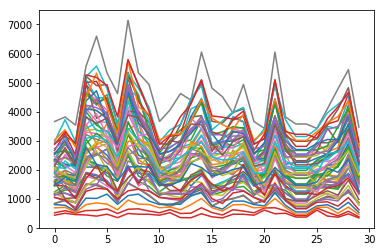

In [75]:
test = resampling(rain,30)
test.plot(legend=False)

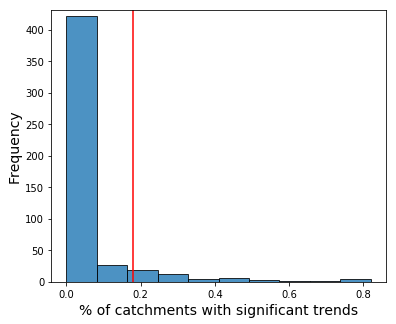

In [76]:
fieldSign(runoff,30,histogram=True)
plt.savefig("Plots/fieldSignificance_distribution_example.png",dpi=400,bbox_inches='tight')

In [77]:
regionDF = {"sor":sor,
            "ost":ost,
            "vest":vest,
            "trond":trond,
            "nord":nord,
            "finn":finn}
regions = ["sor","ost","vest","trond","nord","finn"]
years = [30,50]
out = {}
for year in years:
    out[f"{year}years"] = {}
    for region in regions:
        regDF = regionDF[region]
        varDF = annualAllVariables(regDF,years=year)
        variables = ("evapo","runoff","rain","snow","precip")
        FS = {}
        for i in range(len(varDF)):
            df = varDF[i]
            var = variables[i]
            results = fieldSign(df,year,NS=10)
            FS[var] = results
        out[f"{year}years"][region] = pd.DataFrame.from_dict(FS,orient="index",columns=["pcrit","percentSignficant","FieldSignificant"])

Made into script and run in the terminal with NS = 500

In [78]:
FSannual = openDict("Results/FS/FieldSignificanceAnnual")

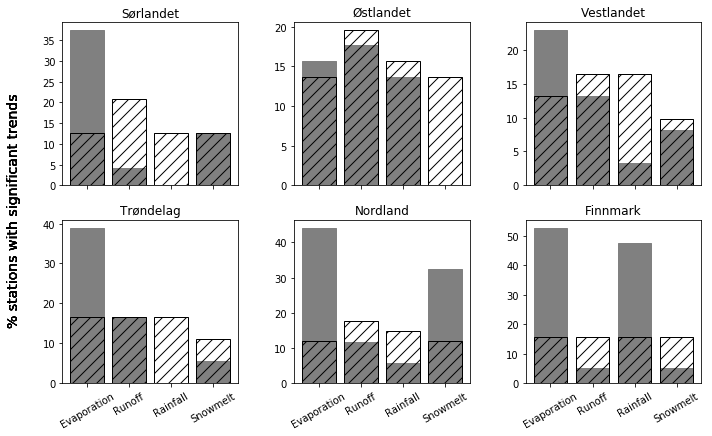

In [79]:
data = FSannual["30years"]
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6),sharex=True)
axes = itertools.cycle((ax[0][0],ax[0][1],ax[0][2],ax[1][0],ax[1][1],ax[1][2]))
plt.tight_layout(pad=2.5)
for region in data.keys():
    df = data[region]*100
    ax = next(axes)
    ax.bar(range(4),df.percentSignficant[:-1],color="grey",edgecolor="grey")
    ax.bar(range(4),df.pcrit[:-1],fill=False,edgecolor="k",hatch="//")
    ax.set_title(regionLabels[region])
    xlabels = ["","Evaporation","Runoff","Rainfall","Snowmelt","Precipitation"]
    ax.set_xticklabels(xlabels,rotation=30)
    fig.text(-0.01, 0.5, "% stations with significant trends", va="center", rotation="vertical",fontsize=14)
plt.savefig("Plots/fieldSignificance_barplots_30year.png",dpi=400,bbox_inches='tight')

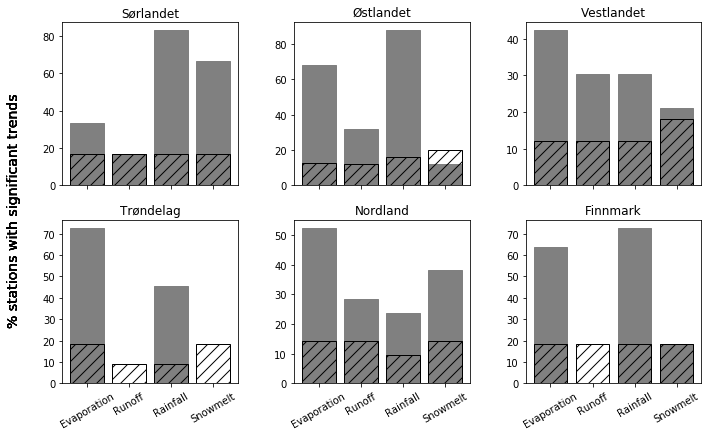

In [80]:
data = FSannual["50years"]
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(10,6),sharex=True)
axes = itertools.cycle((ax[0][0],ax[0][1],ax[0][2],ax[1][0],ax[1][1],ax[1][2]))
plt.tight_layout(pad=2.5)
for region in data.keys():
    df = data[region]*100
    ax = next(axes)
    ax.bar(range(4),df.percentSignficant[:-1],color="grey",edgecolor="grey")
    ax.bar(range(4),df.pcrit[:-1],fill=False,edgecolor="k",hatch="//")
    ax.set_title(regionLabels[region])
    xlabels = ["","Evaporation","Runoff","Rainfall","Snowmelt","Precipitation"]
    ax.set_xticklabels(xlabels,rotation=30)
    fig.text(-0.01, 0.5, "% stations with significant trends", va="center", rotation="vertical",fontsize=14)
plt.savefig("Plots/fieldSignificance_barplots_50year.png",dpi=400,bbox_inches='tight')